X shape: torch.Size([1000, 2])
y shape: torch.Size([1000])
y shape: torch.Size([1000])
features.shape: torch.Size([1000, 2])
labels.shape: torch.Size([1000, 1])
feature[0]: tensor([1.8675, 0.1783]) label[0]: tensor([5.9476])
epoch0,loss1.428584
epoch1,loss0.195056
epoch2,loss0.026748
epoch3,loss0.003711
epoch4,loss0.000556
epoch5,loss0.000120
epoch6,loss0.000059
epoch7,loss0.000051
epoch8,loss0.000050
epoch9,loss0.000050
w的估计误差：tensor([0.0002, 0.0008], grad_fn=<SubBackward0>)
b的估计误差：tensor([-0.0003], grad_fn=<RsubBackward1>)


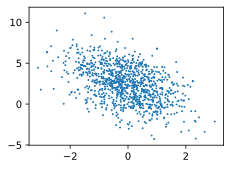

In [25]:
import torch
from d2l import torch as d2l
import random

# 生成随机数据
def gen_random_data(w,b,number_samples):
    '''
    生成（number_samples，len(w))的样本数据，并添加了噪声
    '''
    X = torch.normal(0,1,(number_samples,len(w)))
    print('X shape:',X.shape)
    y = torch.matmul(X,w) + b
    print('y shape:',y.shape)
    y += torch.normal(0,0.01,y.shape)
    print('y shape:',y.shape)
    return X , y.reshape(-1,1)

true_w = torch.tensor([2,-1.04])
true_b = 2.4
number_samples = 1000
features,labels = gen_random_data(true_w,true_b,number_samples)

print("features.shape:",features.shape)
print("labels.shape:",labels.shape)
print('feature[0]:',features[0],'label[0]:',labels[0])
    
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1)  # 只有detach后才能转到numpy里面去     

# 生成小批量迭代器
def data_iter(batch_size,features,labels):
    '''
    获得样本的batch_size随机小批量，可以用for迭代
    '''
    number_samples = len(features)
    indexs = list(range(number_samples))
    random.shuffle(indexs)
    for i in range(0,number_samples,batch_size):
        batch_indexs = indexs[i:min(i+batch_size,number_samples)]
        yield features[batch_indexs],labels[batch_indexs]

batch_size = 10
# for X,y in data_iter(batch_size,features,labels):
#     print(X,'\n',y)
#     print('X shape:',X.shape)
#     print('y shape:',y.shape)
#     break

# 定义模型
def linreg(X,w,b):
    '''线性回归模型'''
    return torch.matmul(X,w)+b

# 定义损失函数
def MSE_loss(y_hat,y):
    '''均方误差'''
    return (y_hat-y.reshape(y_hat.shape))**2/2

# 定义优化器
def sgd(params,lr,batch_size):
    '''小批量随机梯度下降'''
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

# 训练过程

lr = 0.01
epochs = 10
batch_size = 10
net = linreg
loss = MSE_loss
optm = sgd

w = torch.normal(0,1,true_w.shape,requires_grad=True)
b = torch.zeros(1,requires_grad=True)

for epoch in range(epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y)
        l.sum().backward()
        optm([w,b],lr,batch_size)
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch{epoch},loss{float(train_l.mean()):f}')


# 比较真实参数和通过训练学到的参数来评估训练的成功程度
print(f'w的估计误差：{true_w-w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b-b}')


In [21]:
help(torch.Tensor.backward)

Help on function backward in module torch._tensor:

backward(self, gradient=None, retain_graph=None, create_graph=False, inputs=None)
    Computes the gradient of current tensor w.r.t. graph leaves.
    
    The graph is differentiated using the chain rule. If the tensor is
    non-scalar (i.e. its data has more than one element) and requires
    gradient, the function additionally requires specifying ``gradient``.
    It should be a tensor of matching type and location, that contains
    the gradient of the differentiated function w.r.t. ``self``.
    
    This function accumulates gradients in the leaves - you might need to zero
    ``.grad`` attributes or set them to ``None`` before calling it.
    See :ref:`Default gradient layouts<default-grad-layouts>`
    for details on the memory layout of accumulated gradients.
    
    .. note::
    
        If you run any forward ops, create ``gradient``, and/or call ``backward``
        in a user-specified CUDA stream context, see
        :